In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
% matplotlib inline

## Clean data

In [2]:
articles = pd.read_csv('/Users/meghajain/Desktop/all_articles.csv')

In [3]:
articles.columns

Index(['Headline', 'Date', 'Source', 'Body', 'Event Type'], dtype='object')

In [4]:
#remove articles missing information
articles = articles[~((articles['Body'].isnull()) | (articles['Date'].isnull()))]

In [5]:
#fix date columns
tampa = re.compile(r'\s*Tampa Tribune \(Florida\)\s*')
articles['Date'] = articles['Date'].apply(lambda x: re.sub(tampa, '', x))

In [6]:
#convert date to datetime obj
articles['Date'] = pd.to_datetime(articles['Date'])

#### Narrowing in on droughts, clean any sports-related articles

In [7]:
droughts = articles[(articles['Event Type'] == 'Drought')]

In [8]:
len(droughts)

30466

In [9]:
droughts = droughts[~(droughts['Body'].str.contains('coach'))]

In [10]:
droughts = droughts[~((droughts['Body'].str.contains('point')) & (droughts['Body'].str.contains('scored')))]

In [11]:
droughts = droughts[~((droughts['Body'].str.contains('game')) & (droughts['Body'].str.contains('victory')))]

In [12]:
droughts = droughts[~((droughts['Body'].str.contains('game')) & (droughts['Body'].str.contains('scored')))]

In [13]:
droughts = droughts[~((droughts['Body'].str.contains('game')) & (droughts['Body'].str.contains('season')))]

In [14]:
droughts = droughts[~((droughts['Body'].str.contains('shot')) & (droughts['Body'].str.contains('goal')))]

In [15]:
len(droughts)

27540

## Remove NERs

In [16]:
from mitie import *
from collections import defaultdict
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import NMF

In [17]:
ner = named_entity_extractor('/Users/meghajain/Downloads/MITIE-models/english/ner_model.dat')

In [18]:
entities = []

def get_ent_simp(x, listname=entities):
    x = tokenize(str(x))
    entities = ner.extract_entities(x)
    for e in entities:
        rangee = e[0]
        if e[1] == 'LOCATION':
            entity_text = " ".join((x[i]).decode('utf-8') for i in rangee)
            listname.append(entity_text.lower())

In [19]:
droughts['Body'].apply(get_ent_simp)

0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
15        None
16        None
17        None
18        None
19        None
20        None
22        None
23        None
24        None
25        None
26        None
27        None
28        None
29        None
30        None
          ... 
112550    None
112551    None
112552    None
112553    None
112554    None
112555    None
112558    None
112559    None
112560    None
112561    None
112562    None
112563    None
112564    None
112565    None
112566    None
112567    None
112568    None
112569    None
112570    None
112571    None
112572    None
112573    None
112574    None
112575    None
112576    None
112577    None
112578    None
112579    None
112581    None
112582    None
Name: Body, dtype: object

In [20]:
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

In [21]:
STOPWORDS = set(list(stopwords.words('english')) + list(ENGLISH_STOP_WORDS) + list(entities) + list(days))

## Find words in topic
final parameters: min df = 0.01, # topics = 5

In [22]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def nmf_mod(corp):
    max_val = .3
    min_val = .01
    ngram_range_val = (1,2)
    n_topics = 5
    n_top_words = 20
    
    # Use tf-idf features for NMF.
    print("Extracting tf-idf features for NMF...")
    vectorizer_nmf = TfidfVectorizer(strip_accents = 'ascii', ngram_range = ngram_range_val, stop_words = STOPWORDS, min_df = min_val, max_df = max_val)
    dtm_nmf = vectorizer_nmf.fit_transform(corp)


    # Fit the NMF model
    print("Fitting the NMF model with tf-idf features")

    nmf = NMF(n_components=n_topics, random_state=20).fit(dtm_nmf)
    
    print(nmf.components_)
    
    print("\nTopics in NMF model:")
    tfidf_feature_names = vectorizer_nmf.get_feature_names()
    return print_top_words(nmf, tfidf_feature_names, n_top_words), nmf.components_

In [23]:
nmf_mod(droughts['Body'])

Extracting tf-idf features for NMF...
Fitting the NMF model with tf-idf features
[[ 0.05175757  0.          0.         ...,  0.00817316  0.01100471
   0.00047282]
 [ 0.          0.          0.         ...,  0.0107743   0.00536593
   0.03516004]
 [ 0.16532421  0.02018534  0.02493985 ...,  0.00460223  0.0287657
   0.00969107]
 [ 0.          0.          0.         ...,  0.00307483  0.00496227
   0.01185858]
 [ 0.          0.1366458   0.01365088 ...,  0.01056533  0.00919175
   0.00218999]]

Topics in NMF model:
Topic #0:
farmers, prices, crop, food, percent, agriculture, crops, billion, bushels, government, wheat, aid, grain, production, market, cattle, soybean, soybeans, bushel, world
Topic #1:
plants, plant, trees, soil, flowers, says, leaves, native, lawn, spring, summer, sun, shade, watering, roots, fall, tolerant, planted, planting, flower
Topic #2:
fires, firefighters, storm, snow, homes, service, national, normal, rainfall, dry, winds, burned, temperatures, blaze, acres, season, wil

(None, array([[ 0.05175757,  0.        ,  0.        , ...,  0.00817316,
          0.01100471,  0.00047282],
        [ 0.        ,  0.        ,  0.        , ...,  0.0107743 ,
          0.00536593,  0.03516004],
        [ 0.16532421,  0.02018534,  0.02493985, ...,  0.00460223,
          0.0287657 ,  0.00969107],
        [ 0.        ,  0.        ,  0.        , ...,  0.00307483,
          0.00496227,  0.01185858],
        [ 0.        ,  0.1366458 ,  0.01365088, ...,  0.01056533,
          0.00919175,  0.00218999]]))

## Find topics in documents, topics = 5

In [24]:
def nmf_mod(corp):
    max_val = .3
    min_val = 0.01
    ngram_range_val = (1,2)
    n_topics = 5
    n_top_words = 20
    
    # Use tf-idf features for NMF.
    print("Extracting tf-idf features for NMF...")
    vectorizer_nmf = TfidfVectorizer(strip_accents = 'ascii', ngram_range = ngram_range_val, stop_words = 'english', min_df = min_val, max_df = max_val)
    dtm_nmf = vectorizer_nmf.fit_transform(corp)


    # Fit the NMF model
    print("Fitting the NMF model with tf-idf features")

    nmf = NMF(n_components=n_topics, random_state=20).fit(dtm_nmf)
    
    print(nmf.components_)
    
    tfidf_feature_names = vectorizer_nmf.get_feature_names()
    return dtm_nmf, nmf

In [25]:
tfidf, nmf_mod_test = nmf_mod(droughts['Body'])

Extracting tf-idf features for NMF...
Fitting the NMF model with tf-idf features
[[ 0.16281002  0.02289262  0.00489338 ...,  0.01029732  0.01094955
   0.00136804]
 [ 0.00380862  0.11464022  0.03432365 ...,  0.02427064  0.01783429
   0.00645572]
 [ 0.00752815  0.03073274  0.         ...,  0.00721338  0.          0.        ]
 [ 0.          0.0016983   0.00158146 ...,  0.00434801  0.04791745
   0.03283582]
 [ 0.          0.          0.00141187 ...,  0.00671256  0.0140519
   0.01186955]]


In [26]:
out = nmf_mod_test.fit_transform(tfidf)

In [27]:
#shows topic strength for each document
out

array([[ 0.00769971,  0.00628035,  0.        ,  0.0249354 ,  0.02143036],
       [ 0.07389584,  0.        ,  0.00833672,  0.04051872,  0.        ],
       [ 0.03185905,  0.        ,  0.00976544,  0.01054864,  0.00826538],
       ..., 
       [ 0.04947185,  0.01484855,  0.00295781,  0.00450134,  0.0249601 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.09476585],
       [ 0.00306085,  0.03428823,  0.00122915,  0.00394746,  0.00452566]])

In [35]:
#creating document-topic df  
import operator
topics = []
agriculture = []
landscape = []
fires = []
climate = []
water_use = []
for item in out:
    agriculture.append(item[2])
    landscape.append(item[3])
    fires.append(item[1])
    climate.append(item[4])
    water_use.append(item[0])
    max_index, max_value = max(enumerate(item), key=operator.itemgetter(1))
    topics.append(max_index) 

In [36]:
droughts["Topics"] = pd.Series(topics, index=droughts.index)    
droughts["Agriculture"] = pd.Series(agriculture, index=droughts.index)    
droughts['Landscape'] = pd.Series(landscape, index=droughts.index)
droughts['Fires'] = pd.Series(fires, index=droughts.index)
droughts['Climate'] = pd.Series(climate, index=droughts.index)
droughts['Water use'] = pd.Series(water_use, index=droughts.index)

In [30]:
droughts.head()

,Headline,Date,Source,Body,Event Type,Topics,Agriculture,Landscape,Fires,Climate,Water use
0,COMIC DOESN'T ROCK THE BOAT AT STREAMLINED AWA...,2005-02-28,Arizona Republic,Chill out. Those who were worried that Chris R...,Drought,3,0.007700,0.006280,0.000000,0.024935,0.021430
1,"Will Arizonans have to turn off the tap, too?",2015-08-08,Arizona Republic,We've all seen the water situation in Californ...,Drought,0,0.073896,0.000000,0.008337,0.040519,0.000000
2,"GOLF FACES 2-PRONGED ATTACK TOURISM DROP, SALI...",2002-05-22,Arizona Republic,Arizona's tourism drought has filtered down to...,Drought,0,0.031859,0.000000,0.009765,0.010549,0.008265
3,"DROUGHT DIMINISHES RIVER RANCHERS, CITIES NEAR...",2004-07-25,Arizona Republic,Part 1 High in the Rockies at the Colorado's s...,Drought,0,0.090524,0.016202,0.004845,0.002367,0.000000
4,CANDY CORN PLANT PROVES ELUSIVE HERE,2004-07-10,Arizona Republic,QUESTION: The candy corn plant is available in...,Drought,3,0.000000,0.000000,0.018377,0.110856,0.000000


In [90]:
droughts.to_pickle('/Users/meghajain/Desktop/drought.pkl')

## Groupby source and date

In [152]:
droughts = pd.read_pickle("/Users/meghajain/Desktop/Metis/Projects/Final/final_datasets/drought.pkl")

In [146]:
#creating a copy of the df with date as index
drought_bydate = droughts.copy(deep=True)
drought_bydate.set_index(drought_bydate['Date'], inplace=True, drop=True)
drought_grouped = drought_bydate.groupby(by=['Source', pd.TimeGrouper(freq='A'), ""])

In [148]:
drought_grouped.size()

Source                        Date      
Arizona Republic              1999-12-31     53
                              2000-12-31     58
                              2001-12-31     33
                              2002-12-31    171
                              2003-12-31    167
                              2004-12-31    224
                              2005-12-31    152
                              2006-12-31    173
                              2007-12-31    108
                              2008-12-31     66
                              2009-12-31     44
                              2010-12-31     37
                              2011-12-31     56
                              2012-12-31     56
                              2013-12-31     44
                              2014-12-31     59
                              2015-12-31    114
Atlanta Journal-Constitution  1996-12-31      3
                              1997-12-31     25
                              1998-12-31     52

In [39]:
#creating a new df with the average strength for each topic by source and year
trends_bysource = pd.DataFrame({'Agriculture': drought_grouped['Agriculture'].sum()/drought_grouped.size(), 'Landscape': drought_grouped['Landscape'].sum()/drought_grouped.size(), 'Fires': drought_grouped['Fires'].sum()/drought_grouped.size(), 'Climate': drought_grouped['Climate'].sum()/drought_grouped.size(), 'Water use': drought_grouped['Water use'].sum()/drought_grouped.size()}).reset_index()

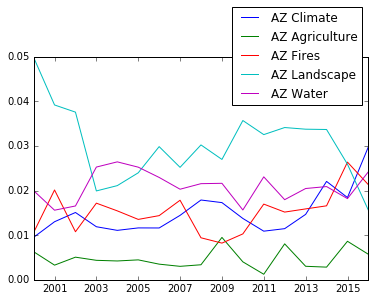

In [102]:
az = trends_bysource[trends_bysource['Source'] == 'Arizona Republic']
az.set_index(az['Date'], inplace=True, drop=True)
plt.plot(az['Climate'], label='AZ Climate')
plt.plot(az['Agriculture'], label='AZ Agriculture')
plt.plot(az['Fires'], label='AZ Fires')
plt.plot(az['Landscape'], label='AZ Landscape')
plt.plot(az['Water use'], label='AZ Water')
plt.legend(bbox_to_anchor=(1,1.25))

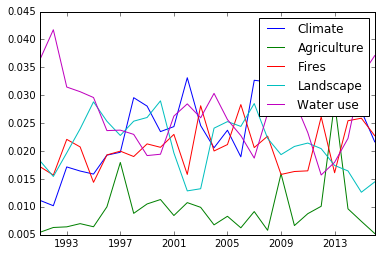

In [93]:
la = trends_bysource[trends_bysource['Source'] == 'LA Times']
la.set_index(la['Date'], inplace=True, drop=True)
plt.plot(la['Climate'])
plt.plot(la['Agriculture'])
plt.plot(la['Fires'])
plt.plot(la['Landscape'])
plt.plot(la['Water use'])
plt.legend()

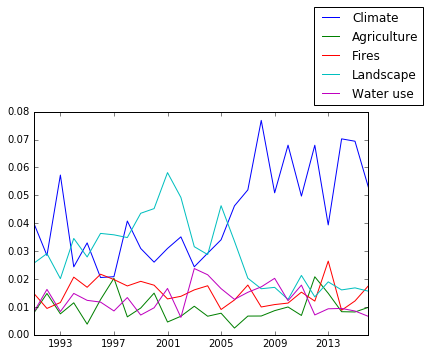

In [48]:
boston = trends_bysource[trends_bysource['Source'] == 'Boston Globe']
boston.set_index(boston['Date'], inplace=True, drop=True)
plt.plot(boston['Climate'])
plt.plot(boston['Agriculture'])
plt.plot(boston['Fires'])
plt.plot(boston['Landscape'])
plt.plot(boston['Water use'])
plt.legend(bbox_to_anchor=(1,1.25), loc='center')

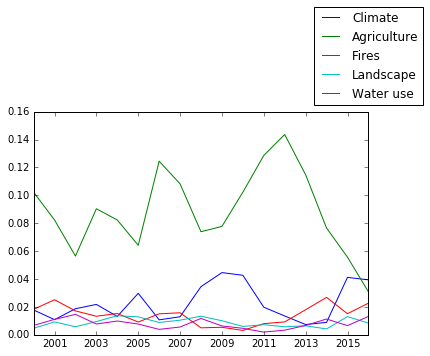

In [128]:
iowa = trends_bysource[trends_bysource['Source'] == 'Des Moines Register']
iowa.set_index(iowa['Date'], inplace=True, drop=True)
plt.plot(iowa['Climate'])
plt.plot(iowa['Agriculture'])
plt.plot(iowa['Fires'])
plt.plot(iowa['Landscape'])
plt.plot(iowa['Water use'])
plt.legend(bbox_to_anchor=(1,1.25), loc='center')

## Groupby date

In [49]:
drought_grouped_date = drought_bydate.groupby(by=[pd.TimeGrouper(freq='A')])
drought_grouped_date.size()

Date
1990-12-31    1609
1991-12-31    2224
1992-12-31    1256
1993-12-31     914
1994-12-31     665
1995-12-31     571
1996-12-31     794
1997-12-31     771
1998-12-31     869
1999-12-31     944
2000-12-31    1369
2001-12-31    1119
2002-12-31    1465
2003-12-31    1137
2004-12-31     788
2005-12-31     761
2006-12-31     949
2007-12-31    1402
2008-12-31    1103
2009-12-31     902
2010-12-31     471
2011-12-31     834
2012-12-31    1107
2013-12-31     802
2014-12-31    1042
2015-12-31    1672
dtype: int64

In [94]:
trends_bydate = pd.DataFrame({'Agriculture': drought_grouped_date['Agriculture'].sum()/drought_grouped_date.size(), 'Landscape': drought_grouped_date['Landscape'].sum()/drought_grouped_date.size(), 'Fires': drought_grouped_date['Fires'].sum()/drought_grouped_date.size(), 'Climate': drought_grouped_date['Climate'].sum()/drought_grouped_date.size(), 'Water use': drought_grouped_date['Water use'].sum()/drought_grouped_date.size()}).reset_index()

In [95]:
trends_bydate.head()

,Date,Agriculture,Climate,Fires,Landscape,Water use
0,1990-12-31,0.011552,0.014681,0.018547,0.017982,0.029362
1,1991-12-31,0.009891,0.012012,0.017235,0.016460,0.036115
2,1992-12-31,0.010754,0.025484,0.020484,0.018642,0.023412
3,1993-12-31,0.014882,0.018169,0.021210,0.023692,0.023651
4,1994-12-31,0.010534,0.020160,0.017013,0.024745,0.022869


In [96]:
trends_bydate.set_index(trends_bydate['Date'], inplace=True, drop=True)

In [97]:
trends_bydate.drop(labels=['Date'],inplace=True,axis=1)

In [98]:
trends_bydate.head()

,Agriculture,Climate,Fires,Landscape,Water use
Date,,,,,
1990-12-31,0.011552,0.014681,0.018547,0.017982,0.029362
1991-12-31,0.009891,0.012012,0.017235,0.016460,0.036115
1992-12-31,0.010754,0.025484,0.020484,0.018642,0.023412
1993-12-31,0.014882,0.018169,0.021210,0.023692,0.023651
1994-12-31,0.010534,0.020160,0.017013,0.024745,0.022869


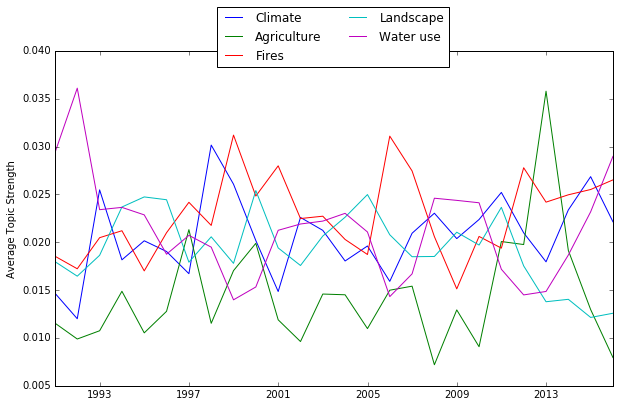

In [127]:
plt.figure(figsize=(10,6))
plt.plot(trends_bydate['Climate'])
plt.plot(trends_bydate['Agriculture'])
plt.plot(trends_bydate['Fires'])
plt.plot(trends_bydate['Landscape'])
plt.plot(trends_bydate['Water use'])
plt.ylabel('Average Topic Strength')
plt.legend(bbox_to_anchor=(0.717, 1.15), ncol=2)
